NECESSARY IMPORTS

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
import os
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model

np.random.seed(2)

READING THE CSV

In [26]:
df=pd.read_csv('lend-or-lose/train.csv')
class_counts = df['Default'].value_counts()
print(class_counts)
df

Default
0    180524
1     23753
Name: count, dtype: int64


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,High School,Self-employed,Single,Yes,No,Business,No,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,High School,Unemployed,Divorced,No,Yes,Education,No,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,Master's,Self-employed,Married,No,No,Other,Yes,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,Bachelor's,Self-employed,Single,Yes,No,Auto,Yes,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,Bachelor's,Part-time,Single,No,Yes,Education,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,KYS1HKNGGE,40,116623,161673,651,79,2,23.44,12,0.87,Bachelor's,Part-time,Divorced,No,No,Home,Yes,0
204273,5MAOH3AOZO,67,62958,189499,460,77,3,9.29,36,0.11,Bachelor's,Self-employed,Single,No,No,Business,Yes,0
204274,5Y9Z6NW29X,62,34372,59645,524,94,3,9.72,60,0.24,PhD,Full-time,Single,Yes,No,Auto,No,0
204275,O51974F566,44,146262,198454,489,7,4,4.31,48,0.30,High School,Self-employed,Married,Yes,No,Home,No,0


ONE-HOT ENCODING

In [27]:
le = LabelEncoder()

# Fit and transform the specified columns
for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    df[col] = le.fit_transform(df[col])

In [28]:
features=df.columns.to_numpy()
features=features[(features!="LoanID") & (features!="Default")]
features  # Removes values at indices 1 and 3

array(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
       'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner'], dtype=object)

CHECKING FOR NULL VALUES

In [29]:
null_value_percentages=(df.isna().sum()/df.shape[0])*100
null_value_percentages

LoanID            0.0
Age               0.0
Income            0.0
LoanAmount        0.0
CreditScore       0.0
MonthsEmployed    0.0
NumCreditLines    0.0
InterestRate      0.0
LoanTerm          0.0
DTIRatio          0.0
Education         0.0
EmploymentType    0.0
MaritalStatus     0.0
HasMortgage       0.0
HasDependents     0.0
LoanPurpose       0.0
HasCoSigner       0.0
Default           0.0
dtype: float64

IMPUTING OUTLIERS (NONE FOUND)

In [30]:
class OutlierRemoval:
    def __init__(self, col):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        inter_quartile_range = q3 - q1
        self.upper_whisker = q3 + inter_quartile_range * 1.5
        self.lower_whisker = q1 - inter_quartile_range * 1.5
        self.has_outliers = False  # Track if outliers exist

    def replace_outlier(self, value):
        # Check if the value is an outlier and set `has_outliers` to True if it is
        if value < self.lower_whisker or value > self.upper_whisker:
            self.has_outliers = True
            return min(max(value, self.lower_whisker), self.upper_whisker)
        return value

def replace_outliers(df, columns):
    outlier_columns = []  # To store column names with outliers
    for col in columns:
        outlier_remover = OutlierRemoval(df[col])
        df[col] = df[col].apply(outlier_remover.replace_outlier)
        if outlier_remover.has_outliers:  # If outliers were replaced
            outlier_columns.append(col)
    print("Columns with outliers:", outlier_columns)  # Print the columns with outliers
    return df

# Replace outliers in the DataFrame `df` for selected columns
df = replace_outliers(df, features)
df


Columns with outliers: []


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,1,2,2,1,0,1,0,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,1,3,0,0,1,2,0,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,2,2,1,0,0,4,1,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,0,2,2,1,0,0,1,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,0,1,2,0,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,KYS1HKNGGE,40,116623,161673,651,79,2,23.44,12,0.87,0,1,0,0,0,3,1,0
204273,5MAOH3AOZO,67,62958,189499,460,77,3,9.29,36,0.11,0,2,2,0,0,1,1,0
204274,5Y9Z6NW29X,62,34372,59645,524,94,3,9.72,60,0.24,3,0,2,1,0,0,0,0
204275,O51974F566,44,146262,198454,489,7,4,4.31,48,0.30,1,2,1,1,0,3,0,0


STANDARDIZATION

In [31]:
scaler=StandardScaler()

normalized_features=scaler.fit_transform(df[features])
normalized_df = pd.DataFrame(normalized_features, columns=features)
normalized_df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,-1.699838,1.413785,1.151487,1.711544,-0.967182,-0.449530,-0.454811,1.415720,1.339989,-0.442742,0.448348,1.226590,0.999936,-1.000406,-0.707810,-1.000563
1,0.234120,-0.649831,-1.715866,1.094714,-0.851727,-0.449530,0.939092,-0.000645,0.993538,-0.442742,1.343560,-1.224023,-1.000064,0.999594,-0.000312,-1.000563
2,-1.166333,0.046770,-0.458437,-0.762072,-1.515594,-0.449530,1.621727,-1.417010,-0.219039,0.450557,0.448348,0.001284,-1.000064,-1.000406,1.414685,0.999437
3,0.634249,-0.839783,1.440049,-0.258537,1.370784,0.445809,0.143437,1.415720,-1.431615,-1.336042,0.448348,1.226590,0.999936,-1.000406,-1.415308,0.999437
4,0.367496,0.845753,-1.488613,1.673779,-1.717640,1.341148,1.656386,-1.417010,-1.691453,-1.336042,-0.446863,1.226590,-1.000064,0.999594,-0.000312,0.999437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,-0.232698,0.875867,0.481625,0.484177,0.562598,-0.449530,1.499667,-1.417010,1.599826,-1.336042,-0.446863,-1.224023,-1.000064,-1.000406,0.707187,0.999437
204273,1.567884,-0.501854,0.874343,-0.718013,0.504870,0.445809,-0.632628,-0.000645,-1.691453,-1.336042,0.448348,1.226590,-1.000064,-1.000406,-0.707810,0.999437
204274,1.234443,-1.235732,-0.958332,-0.315185,0.995555,0.445809,-0.567830,1.415720,-1.128471,1.343857,-1.342074,1.226590,0.999936,-1.000406,-1.415308,-1.000563
204275,0.034055,1.636778,1.000728,-0.535481,-1.515594,1.341148,-1.383075,0.707538,-0.868633,-0.442742,0.448348,0.001284,0.999936,-1.000406,0.707187,-1.000563


PRINCIPAL COMPONENT ANALYSIS

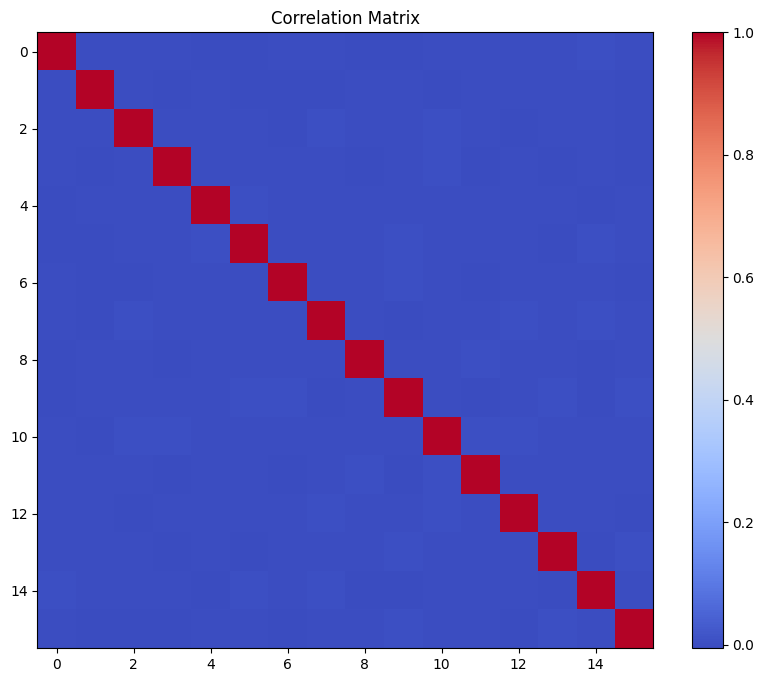

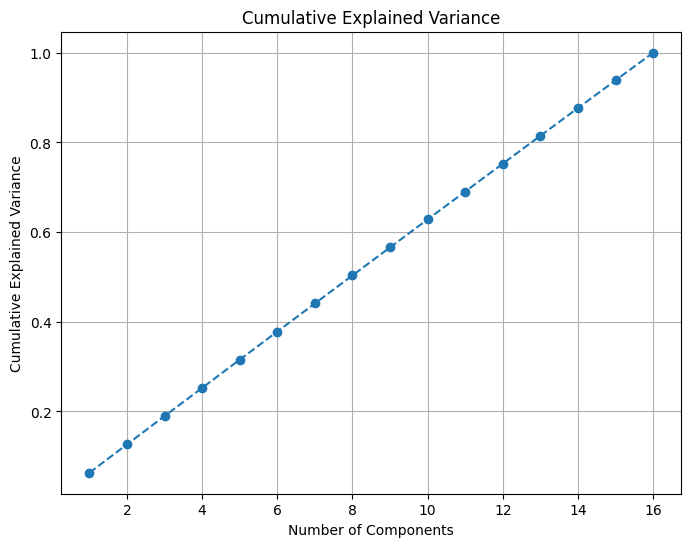

Number of components explaining 95% variance: 16


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
Age,1.000000,0.000029,-0.001023,0.000265,-0.002529,-0.002301,-0.001661,0.000873,-0.004562,-0.002003,0.000021,-0.001440,-0.001404,0.000337,0.002189,-0.001573
Income,0.000029,1.000000,-0.000661,-0.002797,0.001690,-0.003552,-0.004746,-0.002284,-0.000954,0.000649,-0.003611,0.001831,0.000042,-0.001258,-0.001371,-0.003847
LoanAmount,-0.001023,-0.000661,1.000000,0.001075,0.002110,0.000293,-0.003809,0.002243,0.001639,0.001505,0.003463,0.000453,-0.002084,-0.000467,0.001086,-0.001855
CreditScore,0.000265,-0.002797,0.001075,1.000000,0.000182,0.000795,-0.000579,0.000103,-0.001905,-0.000989,0.003706,-0.004145,0.001335,-0.002513,0.000091,-0.002088
MonthsEmployed,-0.002529,0.001690,0.002110,0.000182,1.000000,0.002687,-0.001697,-0.000778,0.001435,-0.000537,-0.000311,-0.000737,-0.000588,0.000468,-0.002039,0.001181
NumCreditLines,-0.002301,-0.003552,0.000293,0.000795,0.002687,1.000000,0.000374,0.000160,-0.000432,0.002659,0.001407,-0.000057,0.000703,-0.002019,0.003017,0.000637
InterestRate,-0.001661,-0.004746,-0.003809,-0.000579,-0.001697,0.000374,1.000000,0.000215,0.000718,0.003775,0.000471,-0.005682,0.000833,-0.001279,0.001454,-0.003725
LoanTerm,0.000873,-0.002284,0.002243,0.000103,-0.000778,0.000160,0.000215,1.000000,0.001630,-0.002689,0.000568,-0.001244,0.002732,0.000617,0.002717,-0.000250
DTIRatio,-0.004562,-0.000954,0.001639,-0.001905,0.001435,-0.000432,0.000718,0.001630,1.000000,0.000848,0.001047,0.004768,-0.001491,0.001033,-0.003143,0.001481
Education,-0.002003,0.000649,0.001505,-0.000989,-0.000537,0.002659,0.003775,-0.002689,0.000848,1.000000,0.001501,-0.004377,0.001620,0.002807,-0.002932,0.002904


In [32]:
correlation_matrix = normalized_df.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation Matrix")
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show()

# Step 2: Perform PCA
pca = PCA()
pca.fit(normalized_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Step 3: Check the number of components that explain sufficient variance (e.g., 95%)
required_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% variance: {required_components}")

correlation_matrix

OVERSAMPLING AND UNDERSAMPLING DATA BECAUSE THE GIVEN DATA IS IMBALANCED (CAN CAUSE MODEL TO BIAS TOWARDS LABEL=0)

In [33]:
ros = RandomOverSampler(random_state=2)
X_oversampled, Y_oversampled = ros.fit_resample(normalized_df, df["Default"])

rus = RandomUnderSampler(random_state=2)
X_undersampled, Y_undersampled = rus.fit_resample(normalized_df, df["Default"])

class_counts = Y_oversampled.value_counts()
print("After oversampling: ",class_counts)

class_counts = Y_undersampled.value_counts()
print("After undersampling: ",class_counts)

ros = RandomOverSampler(random_state=2)
X_oversampled_unnormalized, Y_oversampled_unnormalized = ros.fit_resample(df[features], df["Default"])

rus = RandomUnderSampler(random_state=2)
X_undersampled_unnormalized, Y_undersampled_unnormalized = ros.fit_resample(df[features], df["Default"])

After oversampling:  Default
0    180524
1    180524
Name: count, dtype: int64
After undersampling:  Default
0    23753
1    23753
Name: count, dtype: int64


PERFORMING TEST-TRAIN SPLIT

In [34]:
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(X_oversampled, Y_oversampled, test_size=0.2, random_state=2)
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, Y_undersampled, test_size=0.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Default'], test_size=0.2, random_state=2)

FUNCTION TO TRAIN A MODEL AND CREATE THE SUBMISSION CSV

In [35]:
def train(model,name,sample,X_train,Y_train,X_val,Y_val,X_test,loan_id):
    model.fit(X_train,Y_train)
    y_pred=model.predict(X_val)

    accuracy=accuracy_score(Y_val,y_pred)
    print(f'{name} with {sample}: {accuracy}')

    y_pred=model.predict(X_test)

    submission=pd.DataFrame({
        "LoanID":loan_id,
        "Default": y_pred
    })
    print(f'Results saved in {name}/{name}_{sample}.csv')
    submission.to_csv(f'{name}/{name}_{sample}.csv',index=False)

    return accuracy

FUNCTION TO TRAIN A MODEL USING GRIDSEARCHCV AND CREATE THE SUBMISSION CSV ACCORDING TO THE MODEL WITH BEST PARAMETERS

In [36]:
def train_grid(model,name,sample,X_train,Y_train,X_test):
  print("Started training")
  model.fit(X_train,Y_train)
  best_model=model.best_estimator_
  best_params = model.best_params_
  print("Best parameters:", best_params)
  acc=model.best_score_
  print("Best cross-validation accuracy:", acc)

  y_pred = best_model.predict(X_test)
  submission=pd.DataFrame({
      "LoanID":test_df["LoanID"],
      "Default": y_pred
  })

  submission.to_csv(f"{name}/{name}_{sample}.csv",index=False)

  return acc

In [37]:
def train_with_polynomial_scaling(model, name, sample, X_train, Y_train, X_val, Y_val, X_test, loan_id, degree):
    # Create a pipeline with polynomial scaling and logistic regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),  # Polynomial features
        ('logreg', model)  # Logistic Regression
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, Y_train)

    # Predict on validation data
    y_pred = pipeline.predict(X_val)

    # Compute accuracy
    accuracy = accuracy_score(Y_val, y_pred)
    print(f'{name} with {sample}, Degree {degree}: {accuracy}')

    # Predict on test data
    y_test_pred = pipeline.predict(X_test)

    # Save results
    submission = pd.DataFrame({
        "LoanID": loan_id,
        "Default": y_test_pred
    })
    # os.makedirs(results_dir, exist_ok=True)
    # submission_file = f"{results_dir}/{name}_{sample}.csv"
    # submission.to_csv(submission_file, index=False)
    # print(f"Results saved in {submission_file}")

    return accuracy, submission

# Evaluate multiple degrees
def evaluate_degrees(model, name, sample, X_train, Y_train, X_val, Y_val, X_test, loan_id, degrees):
    best_accuracy = 0
    best_submission = None

    for degree in degrees:
        accuracy, submission = train_with_polynomial_scaling(
            model=model,
            name=name,
            sample=sample,
            X_train=X_train,
            Y_train=Y_train,
            X_val=X_val,
            Y_val=Y_val,
            X_test=X_test,
            loan_id=loan_id,
            degree=degree
        )
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_submission = submission

    best_submission.to_csv(f"{name}/{name}_sample.csv",index=False)

    print(f"Best accuracy for {sample}: {best_accuracy}")

PREPARING THE TEST DATA FOR PREDICTION

In [38]:
test_df=pd.read_csv("lend-or-lose/test.csv")

le = LabelEncoder()

# Fit and transform the specified columns
for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    test_df[col] = le.fit_transform(test_df[col])

test_normalized_df=scaler.transform(test_df[features])
test_normalized_df = pd.DataFrame(test_normalized_df, columns=features)
test_normalized_df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,0.767625,0.774024,-0.496148,0.043584,1.543966,-0.449530,1.514736,-0.000645,-1.518228,1.343857,0.448348,1.226590,0.999936,0.999594,0.707187,-1.000563
1,0.834313,0.232665,0.056842,0.421235,-0.158996,-1.344869,0.256456,-1.417010,-0.305651,-0.442742,-0.446863,-1.224023,0.999936,0.999594,-0.000312,0.999437
2,-1.166333,-0.111348,-0.735736,-0.031946,1.313056,0.445809,0.682915,-1.417010,-0.911940,0.450557,-0.446863,0.001284,0.999936,0.999594,-0.000312,0.999437
3,-1.166333,-0.499929,-1.647642,-1.561434,1.688285,-1.344869,0.184124,-0.708827,-0.392264,-0.442742,-0.446863,1.226590,-1.000064,-1.000406,-0.707810,0.999437
4,-1.299709,-1.356573,-1.501174,0.553413,1.226465,0.445809,0.230838,1.415720,0.820313,1.343857,1.343560,1.226590,-1.000064,0.999594,-0.707810,0.999437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51065,0.500872,0.435581,0.604129,0.339411,-1.024910,-1.344869,0.533730,-1.417010,-0.175732,1.343857,0.448348,-1.224023,0.999936,0.999594,-1.415308,0.999437
51066,-0.966268,-1.039490,-0.229109,-1.278196,-0.245588,1.341148,-0.962644,-0.000645,-0.002507,1.343857,0.448348,0.001284,-1.000064,-1.000406,1.414685,-1.000563
51067,1.567884,0.154056,0.213373,0.987712,-0.245588,-1.344869,1.416786,0.707538,1.253376,-1.336042,-0.446863,-1.224023,-1.000064,-1.000406,-0.000312,-1.000563
51068,-0.099321,0.876534,0.894652,-0.541775,-1.544458,-1.344869,-0.400562,1.415720,-0.782021,-1.336042,-1.342074,0.001284,-1.000064,0.999594,1.414685,0.999437


TRAINING NAIVE BAYES CLASSIFIER MODELS

In [ ]:
os.makedirs("NaiveBayesClassifier", exist_ok=True)
train(GaussianNB(),"NaiveBayesClassifier","oversampled",X_train_oversampled,y_train_oversampled,X_test_oversampled,y_test_oversampled,test_normalized_df,test_df["LoanID"])   #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train(GaussianNB(),"NaiveBayesClassifier","undersampled",X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled,test_normalized_df,test_df["LoanID"])    #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA

NaiveBayesClassifier with oversampled: 0.6787841019249411
Results saved in NaiveBayesClassifier/NaiveBayesClassifier_oversampled.csv
NaiveBayesClassifier with undersampled: 0.6820669332772048
Results saved in NaiveBayesClassifier/NaiveBayesClassifier_undersampled.csv


0.6820669332772048

TRAINING LOGISTIC REGRESSION MODELS

In [30]:
os.makedirs("LogisticRegression", exist_ok=True)

model = LogisticRegression(random_state=2, max_iter=500)

train(model,"LogisticRegression","oversampled",X_train_oversampled,y_train_oversampled,X_test_oversampled,y_test_oversampled,test_normalized_df,test_df["LoanID"])   #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train(model,"LogisticRegression","undersampled",X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled,test_normalized_df,test_df["LoanID"])    #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA

degrees = [2, 3]

# Evaluate for oversampled dataset
evaluate_degrees(
    model=model,
    name="LogisticRegression",
    sample="poly_oversampled",
    X_train=X_train_oversampled,
    Y_train=y_train_oversampled,
    X_val=X_test_oversampled,
    Y_val=y_test_oversampled,
    X_test=test_normalized_df,
    loan_id=test_df["LoanID"],
    degrees=degrees
)

# Evaluate for undersampled dataset
evaluate_degrees(
    model=model,
    name="LogisticRegression",
    sample="poly_undersampled",
    X_train=X_train_undersampled,
    Y_train=y_train_undersampled,
    X_val=X_test_undersampled,
    Y_val=y_test_undersampled,
    X_test=test_normalized_df,
    loan_id=test_df["LoanID"],
    degrees=degrees
)

LogisticRegression with oversampled: 0.6793934358122143
Results saved in LogisticRegression/LogisticRegression_oversampled.csv
LogisticRegression with undersampled: 0.6810145232582614
Results saved in LogisticRegression/LogisticRegression_undersampled.csv
LogisticRegression with poly_oversampled, Degree 2: 0.6879241102340397
LogisticRegression with poly_oversampled, Degree 3: 0.6909430826755297
Best accuracy for poly_oversampled: 0.6909430826755297
LogisticRegression with poly_undersampled, Degree 2: 0.6838560303094086
LogisticRegression with poly_undersampled, Degree 3: 0.6795411492317407
Best accuracy for poly_undersampled: 0.6838560303094086


GRIDSEARCH ON KNN TO FIND OPTIMUM K

In [ ]:
os.makedirs("KNN", exist_ok=True)

param_grid = {
    'n_neighbors': list(range(1, 5)) + list(range(28, 32))
}

# Initialize the KNeighborsClassifier model
knn = KNeighborsClassifier()

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Optimizing for accuracy
    n_jobs=-1             # Use all available cores
)

train_grid(grid_search,"KNN","normalized",normalized_df,df['Default'],test_normalized_df)   #TRAINED WITH NORMALIZED DATA
train_grid(grid_search,"KNN","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)   #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(grid_search,"KNN","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)    #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA
train_grid(grid_search,"KNN","",df[features],df['Default'],test_df[features])   #TRAINED WITHOUT PREPROCESSING DATA
train_grid(grid_search,"KNN","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])   #TRAINED WITH OVERSAMPLED DATA
train_grid(grid_search,"KNN","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)   #TRAINED WITH UNDERSAMPLED DATA

Started training
Best parameters: {'n_neighbors': 29}
Best cross-validation accuracy: 0.8839125296071966
Started training
Best parameters: {'n_neighbors': 1}
Best cross-validation accuracy: 0.9380137819063583
Started training
Best parameters: {'n_neighbors': 31}
Best cross-validation accuracy: 0.6607198568055449
Started training
Best parameters: {'n_neighbors': 30}
Best cross-validation accuracy: 0.8838146217752001
Started training
Best parameters: {'n_neighbors': 1}
Best cross-validation accuracy: 0.9321475197664052
Started training
Best parameters: {'n_neighbors': 1}
Best cross-validation accuracy: 0.9321475197664052


0.9321475197664052

GRIDSEARCH ON DECISION TREE

In [ ]:
os.makedirs("DecisionTree", exist_ok=True)
dt_model = DecisionTreeClassifier(random_state=2)
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'max_features': [None, 'sqrt']
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt,
                           cv=5, scoring='accuracy', n_jobs=-1)

train_grid(grid_search_dt,"DecisionTree","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)   #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(grid_search_dt,"DecisionTree","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)    #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA
train_grid(grid_search_dt,"DecisionTree","",df[features],df['Default'],test_df[features])   #TRAINED WITHOUT PREPROCESSING DATA
train_grid(grid_search_dt,"DecisionTree","normalized",normalized_df,df['Default'],test_normalized_df)   #TRAINED WITH NORMALIZED DATA
train_grid(grid_search_dt,"DecisionTree","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])   #TRAINED WITH OVERSAMPLED DATA
train_grid(grid_search_dt,"DecisionTree","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)   #TRAINED WITH UNDERSAMPLED DATA


Started training
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.9390108795904725
Started training
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.6440901197210893
Started training
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.8822236496100089
Started training
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.8822187541285442
Started training
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.938958255031711
Started train

0.938958255031711

GRIDSEARCH ON RANDOMFOREST

In [ ]:
os.makedirs("RandomForest", exist_ok=True)

rf_model = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt']
}

# Initialize GridSearchCV with the model, parameter grid, and evaluation method
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Evaluation metric
    n_jobs=-1           # Use all available cores
)

train_grid(grid_search,"RandomForest","normalized",normalized_df,df['Default'],test_normalized_df)    #TRAINED WITH NORMALIZED DATA
train_grid(grid_search,"RandomForest","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)    #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(grid_search,"RandomForest","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)   #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA
train_grid(grid_search,"RandomForest","",df[features],df['Default'],test_df[features])    #TRAINED WITHOUT PREPROCESSING DATA
train_grid(grid_search,"RandomForest","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])    #TRAINED WITH OVERSAMPLED DATA
train_grid(grid_search_dt,"RandomForest","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)   #TRAINED WITH UNDERSAMPLED DATA

GRIDSEARCH ON GRADIENT BOOSTING

In [ ]:
os.makedirs("GradientBoosting", exist_ok=True)

gb_model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [ 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

train_grid(grid_search,"GradientBoosting","normalized",normalized_df,df['Default'],test_normalized_df)    #TRAINED WITH NORMALIZED DATA
train_grid(grid_search,"GradientBoosting","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)    #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(grid_search,"GradientBoosting","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)   #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA
train_grid(grid_search,"GradientBoosting","",df[features],df['Default'],test_df[features])    #TRAINED WITHOUT PREPROCESSING DATA
train_grid(grid_search,"GradientBoosting","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])    #TRAINED WITH OVERSAMPLED DATA
train_grid(grid_search_dt,"GradientBoosting","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)   #TRAINED WITH UNDERSAMPLED DATA

GRIDSEARCH ON ADABOOST

In [ ]:
os.makedirs("Adaboost", exist_ok=True)
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=2),
    random_state=2,
    algorithm='SAMME'
)

param_grid = {
    'estimator__max_depth': [3],
    'n_estimators': [200],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_grid(grid_search,"Adaboost","normalized",normalized_df,df['Default'],test_normalized_df)    #TRAINED WITH NORMALIZED DATA
train_grid(grid_search, "Adaboost", "normalized_oversampled", X_oversampled, Y_oversampled, test_normalized_df)    #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(grid_search,"Adaboost","",df[features],df['Default'],test_df[features])    #TRAINED WITHOUT PREPROCESSING DATA
train_grid(grid_search, "Adaboost", "oversampled", X_oversampled_unnormalized, Y_oversampled_unnormalized, test_df[features])   #TRAINED WITH OVERSAMPLED DATA

Started training


GRIDSEARCH ON XGBOOST

In [19]:
os.makedirs("XGboost", exist_ok=True)
xgb_model = XGBClassifier(random_state=2)

param_grid = {
    'n_estimators': [ 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_grid(grid_search,"XGboost","normalized",normalized_df,df['Default'],test_normalized_df)   #TRAINED WITH NORMALIZED DATA
train_grid(grid_search,"XGboost","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)   #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(grid_search,"XGboost","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)    #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA
train_grid(grid_search,"XGboost","",df[features],df['Default'],test_df[features])   #TRAINED WITHOUT PREPROCESSING DATA
train_grid(grid_search,"XGboost","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])   #TRAINED WITH OVERSAMPLED DATA
train_grid(grid_search,"XGboost","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_df[features])   #TRAINED WITH UNDERSAMPLED DATA

Started training
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.8862378011064983
Started training
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.7113707851638533
Started training
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.6839017234574398
Started training
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.8862378011064983
Started training
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.7113707851638533
Started training


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation accuracy: 0.7113707851638533


0.7113707851638533

In [16]:
os.makedirs("SVM", exist_ok=True)

param_grid = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'kernel': ['linear', 'rbf'],       # Kernel type
    'gamma': ['auto', 0.1, 1]  # Kernel coefficient (used for rbf, poly, sigmoid)
}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=2, cv=3, scoring='accuracy', n_jobs=-1)

train_grid(random_search,"SVM","normalized",normalized_df,df['Default'],test_normalized_df)   #TRAINED WITH NORMALIZED DATA
train_grid(random_search,"SVM","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)   #TRAINED WITH NORMALIZED AND OVERSAMPLED DATA
train_grid(random_search,"SVM","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)    #TRAINED WITH NORMALIZED AND UNDERSAMPLED DATA
train_grid(random_search,"SVM","",df[features],df['Default'],test_df[features])   #TRAINED WITHOUT PREPROCESSING DATA
train_grid(random_search,"SVM","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])   #TRAINED WITH OVERSAMPLED DATA
train_grid(random_search,"SVM","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_df[features])   #TRAINED WITH UNDERSAMPLED DATA

Started training


In [41]:
os.makedirs("NeuralNetwork", exist_ok=True)

# Define the model creation function
def create_nn_model(activation='sigmoid', dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=len(features), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
model_instance = create_nn_model()

nn_model = KerasClassifier(
    model=create_nn_model,
    verbose=0  # Suppress detailed logs
)

model_instance.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'model__activation': ['sigmoid'],
    'model__dropout_rate': [0.2], #0.4
    #'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32], #64
    'epochs': [50], #100
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Function to train and evaluate the neural network
def train_nn(grid_search, model_name, preprocessing_name, X_train, y_train, X_test):
    # Split training data into train and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
     # Fit the model using the training split
    grid_search.fit(X_train_split, y_train_split)
    # Best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Params for {model_name} ({preprocessing_name}): {best_params}")
    # Predict on test and evaluate accuracy using validation data
    y_val_pred = (grid_search.best_estimator_.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Accuracy for {model_name} ({preprocessing_name}): {accuracy}")
    # Predict on test data (no accuracy calculation here since no labels)
    y_test_pred = (grid_search.best_estimator_.predict(X_test) > 0.5).astype(int)
    
    return best_params, accuracy, y_test_pred

# Train the model on various preprocessing strategies
train_nn(grid_search, "NeuralNetwork", "normalized", normalized_df[features], df['Default'], test_normalized_df[features])  # Normalized Data
train_nn(grid_search, "NeuralNetwork", "normalized_oversampled", X_oversampled, Y_oversampled, test_normalized_df[features])  # Oversampled Data
train_nn(grid_search, "NeuralNetwork", "normalized_undersampled", X_train_undersampled, y_train_undersampled, test_normalized_df[features])  # Undersampled Data
train_nn(grid_search, "NeuralNetwork", "", df[features], df['Default'], test_df[features])  # Unprocessed Data
train_nn(grid_search, "NeuralNetwork", "oversampled", X_oversampled_unnormalized, Y_oversampled_unnormalized, test_df[features])  # Oversampled Data
train_nn(grid_search, "NeuralNetwork", "undersampled", X_undersampled_unnormalized, Y_undersampled_unnormalized, test_df[features])  # Undersampled Data

In [ ]:
# BEST model using concepts we have learnt in class

# Create directory for saving model results
os.makedirs("NeuralNetwork", exist_ok=True)

# Define the model creation function
def create_nn_model(activation='sigmoid', dropout_rate=0.2, optimizer='adam', learning_rate=0.001): 
    # Define the optimizer with the learning rate
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = optimizer  # Handle other optimizers if needed
    model = Sequential()
    model.add(Dense(64, input_dim=len(features), activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=optimizer_instance, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize Scikeras KerasClassifier
nn_model = KerasClassifier(
    model=create_nn_model,
    verbose=0  # Suppress detailed logs
)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'model__activation': ['sigmoid'],
    'model__optimizer': ['adam'],
    'model__learning_rate': [0.0005],
    'batch_size': [64], 
    'epochs': [150],   
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Function to train and evaluate the neural network
def train_nn(grid_search, model_name, preprocessing_name, X_train, y_train, X_test):
    # Split training data into train and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
     # Fit the model using the training split
    grid_search.fit(X_train_split, y_train_split)
    # Best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Params for {model_name} ({preprocessing_name}): {best_params}")
    # Predict on test and evaluate accuracy using validation data
    y_val_pred = (grid_search.best_estimator_.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Accuracy for {model_name} ({preprocessing_name}): {accuracy}")
    # Predict on test data (no accuracy calculation here since no labels)
    y_test_pred = (grid_search.best_estimator_.predict(X_test) > 0.5).astype(int)
    
    return best_params, accuracy, y_test_pred

# Train the model on various preprocessing strategies
best_params ,accuracy , y_test_pred = train_nn(grid_search, "NeuralNetwork", "normalized", normalized_df[features], df['Default'], test_normalized_df[features])  # Normalized Data

submission=pd.DataFrame({
      "LoanID":test_df["LoanID"],
      "Default": y_test_pred
  })

submission.to_csv(f"NeuralNetwork_normalized.csv",index=False)